# 14.38 PS3
For this problem set, I have selected problems 1 & 3 from PM2A and problems 2 & 3 from PM2B.

## PM2(A) - Problem 1
In this problem, we solve the lasso minimization problem for one regressor and interpret the results. The problem is as follows:

$$\min_{b \in \mathbb{R}} F = \min_{b \in \mathbb{R}} \sum_i (Y_i - bX_i)^2 + \lambda \hat{\psi} |b|$$

Taking FOCs, we find that

$$ \frac{\partial F}{\partial b} = 0 = -2 \sum_i X_i Y_i + b^2\sum_i X_i^2 \pm \lambda \hat{\psi}, \, b \gtrless 0$$

Solving for $b$, we find that

$$ \hat{b} = \frac{\sum_i X_iY_i}{\sum_i X_i^2} \mp \frac{\lambda \hat{\psi}}{2\sum_i X_i^2}, \, b \gtrless 0$$

A basic interpretation emerges. We see that our $\hat{b}$ is equal to the OLS regression estimator for demeaned $X$ and $Y$, plus a correction term that corrects towards 0. If we plug in a typical penalty loading of $\hat{\psi} = \sqrt{\mathbb{E}_n X_i^2}$, then our expression for $\hat{b}$ becomes

$$ \hat{b} = \frac{\sum_i X_iY_i}{\sum_i X_i^2} \mp \frac{\lambda}{2\sqrt{n\sum_i X_i^2}}$$


Typically, we scale our penalization parameter $\lambda$ by $\sqrt{n}$, so this penalty does not generally depend $n$ directly, but is inversely proportional to the sample standard deviation of $X_i$.

## PM2(A) - Problem 2

In this problem, I will take a second look at the results from the notebook that compares different methods of penalized regression. I will replicate the results of the approximately sparse data generating process, and I will also demonstrate the success of various methods for a dense data generating process.

Essentially, we will use a set of randomly generated data $X$, and two functions, $G_s(X)$ and $G_d(X)$ to generate data that is approximately sparse (where regressors decay polynomially as $1/j^2$) and data that is dense (regressors will generally be small but tightly packed, so lasso selection would be misleading). We can then generate our $Y_s$ and $Y_d$ using Gaussian noise.

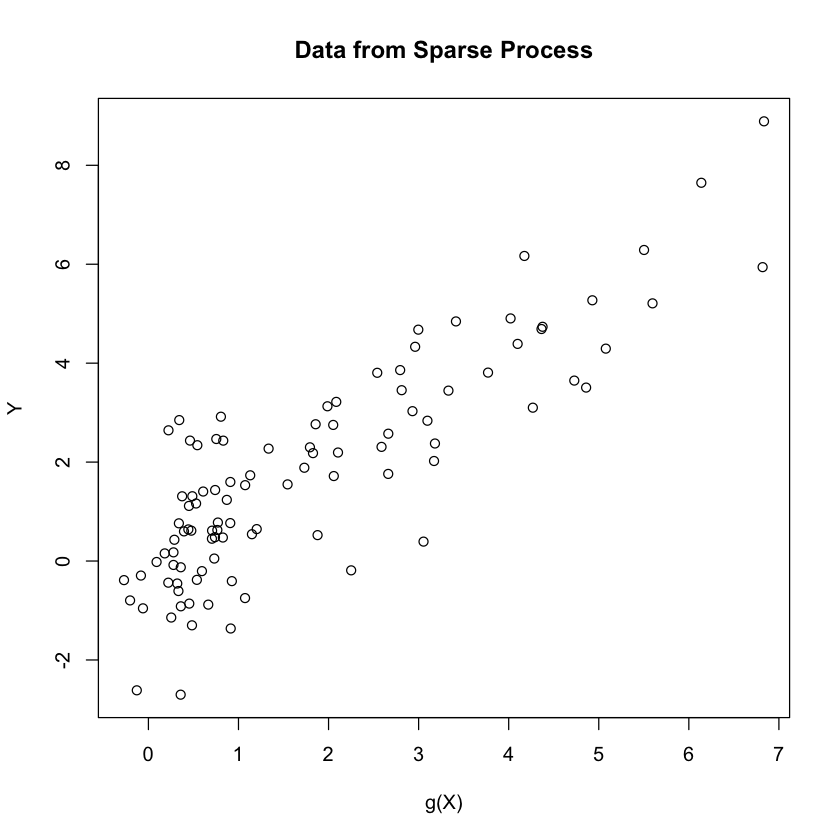

[1] "theoretical R2 for approximately sparse model:"
[2] "0.629720291494432"                             
[1] "theoretical R2 for dense model:" "0.808574788580385"              


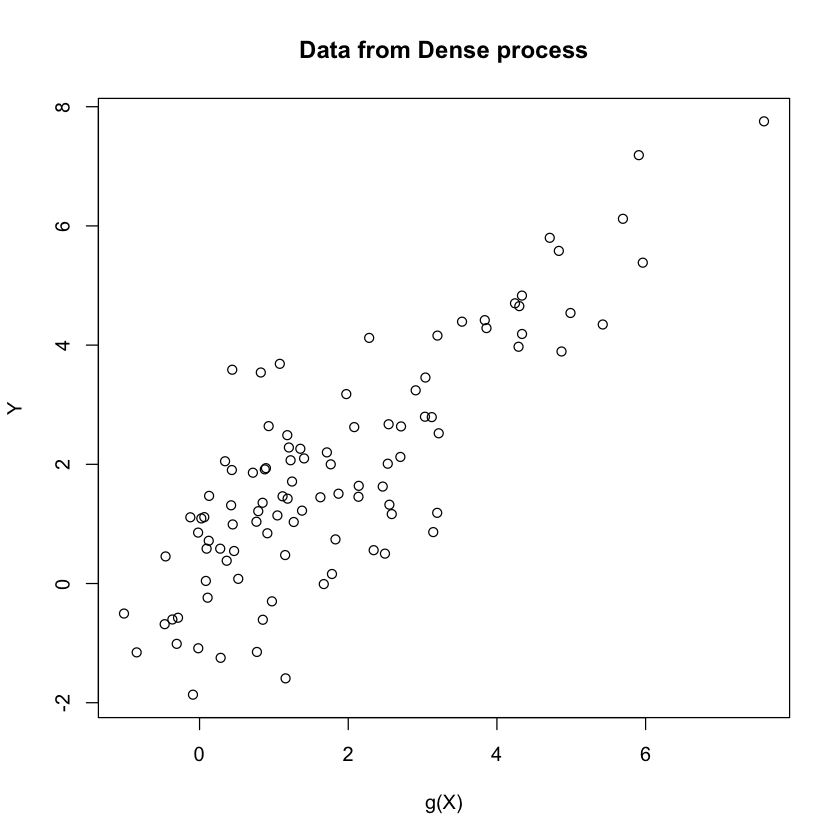

In [120]:
#data generating process
set.seed(1)

n = 100
p = 400

Z= runif(n)-1/2
W = matrix(runif(n*p)-1/2, n, p)



beta.sparse = 1/seq(1:p)^2   # approximately sparse beta
beta.dense = rnorm(p)*.1   # dense beta
gX.sparse = exp(4*Z)+ W%*%beta.sparse  # leading term nonlinear
X.sparse = cbind(Z, Z^2, Z^3, W )  # polynomials in Zs will be approximating exp(4*Z)
gX.dense = exp(4*Z) + W%*%beta.dense
X.dense = cbind(Z, Z^2, Z^3, W)



Y.sparse = gX.sparse + rnorm(n) #generate Y
Y.dense = gX.dense + rnorm(n)


plot(gX.sparse, Y.sparse, xlab="g(X)", ylab="Y", main="Data from Sparse Process")    #plot V vs g(X)
plot(gX.dense, Y.dense, xlab="g(X)", ylab="Y", main="Data from Dense process")

print( c("theoretical R2 for approximately sparse model:", var(gX.sparse)/var(Y.sparse)))
print( c("theoretical R2 for dense model:", var(gX.dense)/var(Y.dense)))


Now that we have our two types of data, we can use various estimation methods to estimate $\hat{Y_i}$ in sample. We will include lasso, post-lasso, cross-validated lasso, ridge, elastic net, and lava. 

Brief explanations are as follows
* Lasso - Explored before, penalizes absolute values of coefficients
* Post-lasso - Uses lasso for variable selection before OLS
* Cross-validated lasso - Uses lasso, but uses cross-validation methods to determine proper parameterization
* Ridge - penalizes the square of the coefficients
* Elastic net - Linear combination of lasso and ridge methods
* Lava - selects some regressors as approximately sparse, and some as dense, then performs lasso and ridge on them, respectively

After we estimate coefficients, we can compare results.


In [121]:
library(glmnet)
fit.lasso.sparse.cv   <- cv.glmnet(X.sparse, Y.sparse, family="gaussian", alpha=1)  # family gaussian means that we'll be using square loss
fit.ridge.sparse   <- cv.glmnet(X.sparse, Y.sparse, family="gaussian", alpha=0)     # family gaussian means that we'll be using square loss
fit.elnet.sparse   <- cv.glmnet(X.sparse, Y.sparse, family="gaussian", alpha=.5)    # family gaussian means that we'll be using square loss

yhat.lasso.sparse.cv    <- predict(fit.lasso.sparse.cv, newx = X.sparse)            # predictions
yhat.ridge.sparse   <- predict(fit.ridge.sparse, newx = X.sparse)
yhat.elnet.sparse   <- predict(fit.elnet.sparse, newx = X.sparse)

MSE.lasso.sparse.cv <- summary(lm((gX-yhat.lasso.sparse.cv)^2~1))$coef[1:2]  # report MSE and standard error for MSE for approximating g(X)
MSE.ridge.sparse <- summary(lm((gX-yhat.ridge.sparse)^2~1))$coef[1:2]        # report MSE and standard error for MSE for approximating g(X)
MSE.elnet.sparse <- summary(lm((gX-yhat.elnet.sparse)^2~1))$coef[1:2]        # report MSE and standard error for MSE for approximating g(X)

library(hdm) 
fit.rlasso.sparse  <- rlasso(Y.sparse~X.sparse,  post=FALSE)      # lasso with plug-in penalty level
fit.rlasso.post.sparse <- rlasso(Y.sparse~X.sparse,  post=TRUE)    # post-lasso with plug-in penalty level

yhat.rlasso.sparse   <- predict(fit.rlasso.sparse)            #predict g(X) for values of X
yhat.rlasso.post.sparse   <- predict(fit.rlasso.post.sparse)  #predict g(X) for values of X

MSE.lasso.sparse <- summary(lm((gX.sparse-yhat.rlasso.sparse)^2~1))$coef[1:2]       # report MSE and standard error for MSE for approximating g(X)
MSE.lasso.post.sparse <- summary(lm((gX.sparse-yhat.rlasso.post.sparse)^2~1))$coef[1:2]  # report MSE and standard error for MSE for approximating g(X)


lava.predict<- function(X,Y, iter=5){
    
    g1 = predict(rlasso(X, Y, post=F))  #lasso step fits "sparse part"
    m1 =  predict(glmnet(X, as.vector(Y-g1), family="gaussian", alpha=0, lambda =20),newx=X ) #ridge step fits the "dense" part

    i=1
    
    while(i<= iter) {
        g1 = predict(rlasso(X, Y, post=F))   #lasso step fits "sparse part"
        m1 = predict(glmnet(X, as.vector(Y-g1), family="gaussian",  alpha=0, lambda =20),newx=X );  #ridge step fits the "dense" part
        i = i+1
    }

    return(g1+m1);
}


yhat.lava.sparse = lava.predict(X.sparse,Y.sparse)
MSE.lava.sparse <- summary(lm((gX.sparse-yhat.lava.sparse)^2~1))$coef[1:2]       # report MSE and standard error for MSE for approximating g(X)

In [122]:
fit.lasso.dense.cv   <- cv.glmnet(X.dense, Y.dense, family="gaussian", alpha=1)  # family gaussian means that we'll be using square loss
fit.ridge.dense  <- cv.glmnet(X.dense, Y.dense, family="gaussian", alpha=0)     # family gaussian means that we'll be using square loss
fit.elnet.dense  <- cv.glmnet(X.dense, Y.dense, family="gaussian", alpha=.5)    # family gaussian means that we'll be using square loss

yhat.lasso.dense.cv    <- predict(fit.lasso.dense.cv, newx = X.dense)            # predictions
yhat.ridge.dense   <- predict(fit.ridge.dense, newx = X.dense)
yhat.elnet.dense   <- predict(fit.elnet.dense, newx = X.dense)

MSE.lasso.dense.cv <- summary(lm((gX.dense-yhat.lasso.dense.cv)^2~1))$coef[1:2]  # report MSE and standard error for MSE for approximating g(X)
MSE.ridge.dense <- summary(lm((gX.dense-yhat.ridge.dense)^2~1))$coef[1:2]        # report MSE and standard error for MSE for approximating g(X)
MSE.elnet.dense <- summary(lm((gX.dense-yhat.elnet.dense)^2~1))$coef[1:2]        # report MSE and standard error for MSE for approximating g(X)


fit.rlasso.dense  <- rlasso(Y.dense~X.dense,  post=FALSE)      # lasso with plug-in penalty level
fit.rlasso.post.dense <- rlasso(Y.dense~X.dense,  post=TRUE)    # post-lasso with plug-in penalty level

yhat.rlasso.dense   <- predict(fit.rlasso.dense)            #predict g(X) for values of X
yhat.rlasso.post.dense   <- predict(fit.rlasso.post.dense)  #predict g(X) for values of X

MSE.lasso.dense <- summary(lm((gX.dense-yhat.rlasso.dense)^2~1))$coef[1:2]       # report MSE and standard error for MSE for approximating g(X)
MSE.lasso.post.dense <- summary(lm((gX.dense-yhat.rlasso.post.dense)^2~1))$coef[1:2]  # report MSE and standard error for MSE for approximating g(X)


lava.predict<- function(X,Y, iter=5){
    
    g1 = predict(rlasso(X, Y, post=F))  #lasso step fits "sparse part"
    m1 =  predict(glmnet(X, as.vector(Y-g1), family="gaussian", alpha=0, lambda =20),newx=X ) #ridge step fits the "dense" part

    i=1
    
    while(i<= iter) {
        g1 = predict(rlasso(X, Y, post=F))   #lasso step fits "sparse part"
        m1 = predict(glmnet(X, as.vector(Y-g1), family="gaussian",  alpha=0, lambda =20),newx=X );  #ridge step fits the "dense" part
        i = i+1
    }

    return(g1+m1);
}


yhat.lava.dense = lava.predict(X.dense,Y.dense)
MSE.lava.dense <- summary(lm((gX.dense-yhat.lava.dense)^2~1))$coef[1:2]       # report MSE and standard error for MSE for approximating g(X)

In [123]:
library(xtable)
table.sparse<- matrix(0, 6, 2)
table.sparse[1,1:2]   <- MSE.lasso.sparse.cv
table.sparse[2,1:2]   <- MSE.ridge.sparse
table.sparse[3,1:2]   <- MSE.elnet.sparse
table.sparse[4,1:2]   <- MSE.lasso.sparse
table.sparse[5,1:2]   <- MSE.lasso.post.sparse
table.sparse[6,1:2]   <- MSE.lava.sparse


colnames(table.sparse)<- c("MSE", "S.E. for MSE")
rownames(table.sparse)<- c("Cross-Validated Lasso (sparse)", "Cross-Validated ridge (sparse)","Cross-Validated elnet (sparse)",
                    "Lasso (sparse)","Post-Lasso (sparse)","Lava (sparse)")
tab.sparse <- xtable(table.sparse, digits =3)


table.dense <- matrix(0, 6, 2)
table.dense[1,1:2]   <- MSE.lasso.dense.cv
table.dense[2,1:2]   <- MSE.ridge.dense
table.dense[3,1:2]   <- MSE.elnet.dense
table.dense[4,1:2]   <- MSE.lasso.dense
table.dense[5,1:2]   <- MSE.lasso.post.dense
table.dense[6,1:2]   <- MSE.lava.dense

colnames(table.dense) <- c("MSE", "S.E. for MSE")
rownames(table.dense) <- c("Cross-Validated Lasso (dense)", "Cross-Validated ridge (dense)","Cross-Validated elnet (dense)",
                    "Lasso (dense)","Post-Lasso (dense)","Lava (dense)")

tab.dense <- xtable(table.dense)

tab.sparse
tab.dense



,MSE,S.E. for MSE
Cross-Validated Lasso (sparse),0.3146165,0.04638556
Cross-Validated ridge (sparse),2.9382110,0.45644679
Cross-Validated elnet (sparse),0.4602046,0.07240485
Lasso (sparse),0.1657006,0.02410496
Post-Lasso (sparse),0.1118944,0.01631161
Lava (sparse),0.2090968,0.02982782


,MSE,S.E. for MSE
Cross-Validated Lasso (dense),0.9324562,0.12714353
Cross-Validated ridge (dense),2.0612147,0.29762883
Cross-Validated elnet (dense),1.1131345,0.15367242
Lasso (dense),0.4943972,0.06790278
Post-Lasso (dense),0.4521560,0.06379371
Lava (dense),0.4458960,0.05920733


Surprisingly, Ridge does not perform as well as we would expect for the dense model. It's possible that the dense model as we have constructed it is not really "dense" in the correct sense. The coefficients might be too small, in this case. Unsurprisingly, Lava performs very well in both examples, as does post-lasso.

We can also plot some of our fitted values for $g(X)$ against actual values, for different estimation methods.

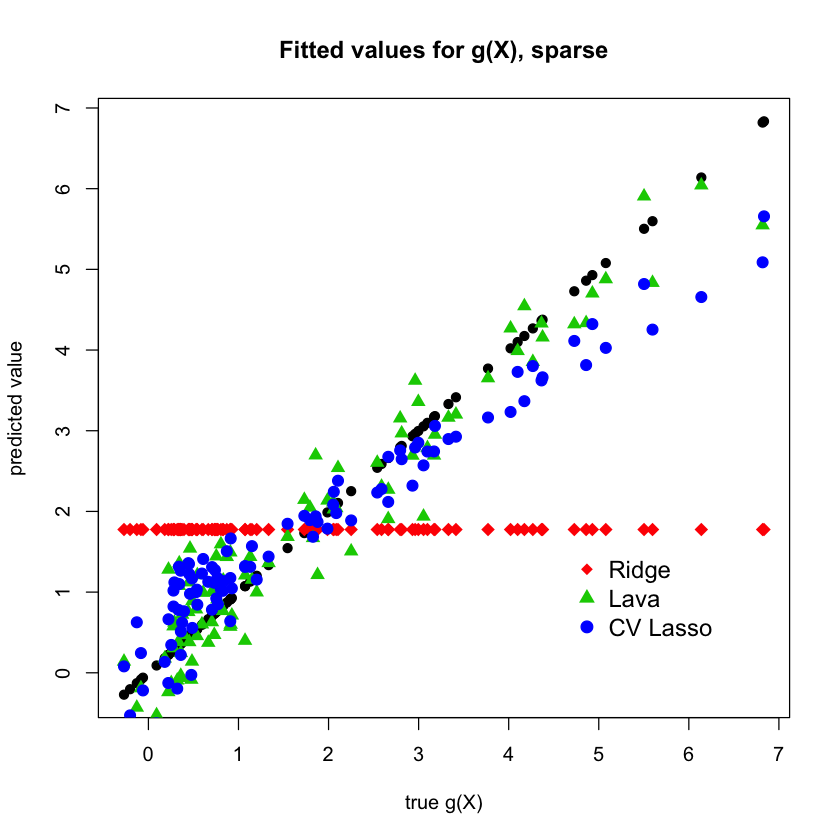

In [124]:

plot(gX.sparse, gX.sparse, pch=19, cex=1, ylab="predicted value", xlab="true g(X)", main="Fitted values for g(X), sparse")

points(gX.sparse, yhat.ridge.sparse, col=2, pch=18, cex = 1.5 )
points(gX.sparse,  yhat.lava.sparse, col=3, pch=17,  cex = 1.2  )
points( gX.sparse, yhat.lasso.sparse.cv,col=4, pch=19,  cex = 1.2 )


legend("bottomright", 
  legend = c("Ridge", "Lava", "CV Lasso"), 
  col = c(2,3,4), 
  pch = c(18,17, 19), 
  bty = "n", 
  pt.cex = 1.3, 
  cex = 1.2, 
  text.col = "black", 
  horiz = F , 
  inset = c(0.1, 0.1))

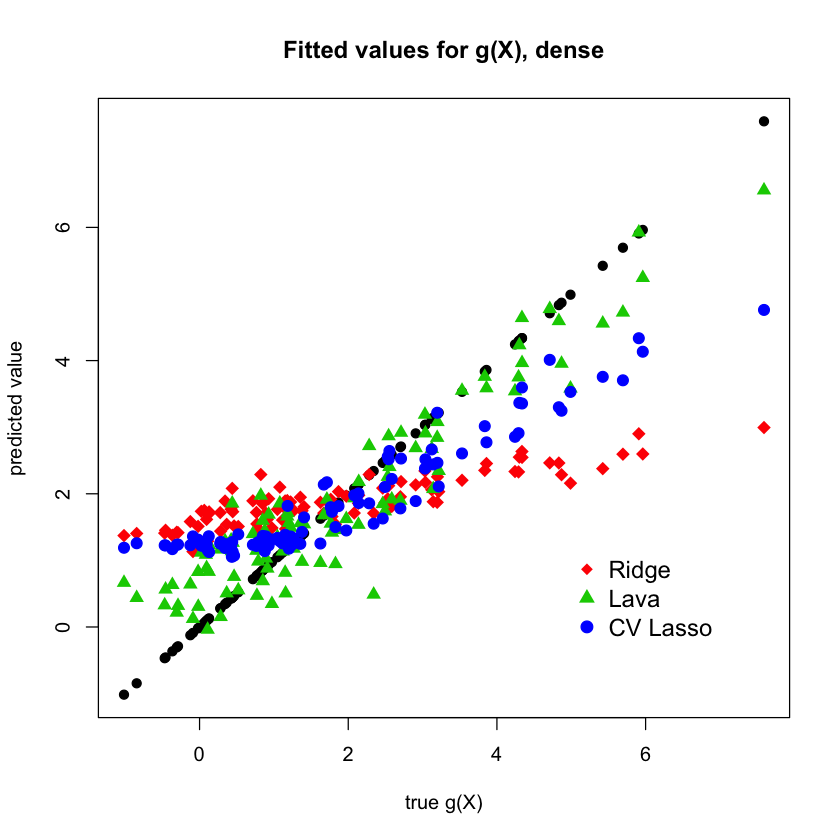

In [125]:

plot(gX.dense, gX.dense, pch=19, cex=1, ylab="predicted value", xlab="true g(X)", main="Fitted values for g(X), dense")

points(gX.dense, yhat.ridge.dense, col=2, pch=18, cex = 1.5 )
points(gX.dense,  yhat.lava.dense, col=3, pch=17,  cex = 1.2  )
points( gX.dense, yhat.lasso.dense.cv,col=4, pch=19,  cex = 1.2 )


legend("bottomright", 
  legend = c("Ridge", "Lava", "CV Lasso"), 
  col = c(2,3,4), 
  pch = c(18,17, 19), 
  bty = "n", 
  pt.cex = 1.3, 
  cex = 1.2, 
  text.col = "black", 
  horiz = F , 
  inset = c(0.1, 0.1))

## PM2(B) - Problem 2
In this problem, we analyze macroeconomic data to provide some evidence for or against the convergence hypothesis (that less wealthy nations grow faster than wealthier nations). This can be a tricky empirical question, because we are interested in a fairly large number of controls, but there are relatively few countries in the world (let alone countries with good economic data). Therefore, we might think that OLS runs into trouble in estimating the parameters in question. We're interested in a model like

$$ Y = \beta_1 D + \beta'W + \varepsilon$$

where $Y$ is GDP growth, $D$ is initial GDP, and $W$ is a set of controls that range from education to political stability. Let's load in our data.


In [126]:
library(hdm)
growth <- GrowthData
dim(growth)
str(growth)

[1] 90 63

'data.frame':	90 obs. of  63 variables:
 $ Outcome  : num  -0.0243 0.1005 0.0671 0.0641 0.0279 ...
 $ intercept: int  1 1 1 1 1 1 1 1 1 1 ...
 $ gdpsh465 : num  6.59 6.83 8.9 7.57 7.16 ...
 $ bmp1l    : num  0.284 0.614 0 0.2 0.174 ...
 $ freeop   : num  0.153 0.314 0.204 0.249 0.299 ...
 $ freetar  : num  0.04389 0.06183 0.00919 0.03627 0.03737 ...
 $ h65      : num  0.007 0.019 0.26 0.061 0.017 0.023 0.039 0.024 0.402 0.145 ...
 $ hm65     : num  0.013 0.032 0.325 0.07 0.027 0.038 0.063 0.035 0.488 0.173 ...
 $ hf65     : num  0.001 0.007 0.201 0.051 0.007 0.006 0.014 0.013 0.314 0.114 ...
 $ p65      : num  0.29 0.91 1 1 0.82 0.5 0.92 0.69 1 1 ...
 $ pm65     : num  0.37 1 1 1 0.85 0.55 0.94 0.69 1 1 ...
 $ pf65     : num  0.21 0.65 1 1 0.81 0.5 0.92 0.69 1 1 ...
 $ s65      : num  0.04 0.16 0.56 0.24 0.17 0.08 0.17 0.14 0.9 0.28 ...
 $ sm65     : num  0.06 0.23 0.62 0.22 0.15 0.1 0.21 0.14 0.9 0.26 ...
 $ sf65     : num  0.02 0.09 0.51 0.31 0.13 0.07 0.12 0.13 0.9 0.4 ...
 $ fert65

Besides our dependent variable and our regressor of interest, we have $p=60$ controls, and $n=90$ observations, so $p/n$ is certainly not small here. Again, this is an environment in which OLS inference does not perform well. We want to compare OLS and another estimation method, "double lasso". In double lasso estimation, we partial out using lasso, and then estimate the coefficients based on the residuals from our lasso regression. Let's estimate our OLS model.

In [127]:
ols <- lm(Outcome~.-1,data=growth)
results.ols <- summary(ols)

coef.ols <- results.ols$coef["gdpsh465",1]
se.ols <- results.ols$coef["gdpsh465", 2]
ci.ols <- confint(ols)["gdpsh465",]



Now that we have stored our OLS results, we can proceed with our double lasso. First, we will partial out using lasso. To do this, we estimate a regression of our outcome variable on our controls, and we also estimate a separate regression of our regressor of interest on our controls, storing the residuals from both. Mathematically, we estimate

$$Y = \gamma'W + \tilde{y}$$
$$D = \delta'W + \tilde{d}$$

In [128]:
Y <- growth[, 1, drop = F] # output variable
W <- as.matrix(growth)[, -c(1, 2,3)] # controls
D <- growth[, 3, drop = F] # target regressor

r.Y <- rlasso(x=W,y=Y)$res # creates the "residual" output variable
r.D <- rlasso(x=W,y=D)$res # creates the "residual" target regressor

Finally, now that we've partialled out the effect of controls on both our regressor of interest and our outcome variable, we can estimate our regression. We estimate

$$ \tilde{y} = \tilde{d} + \xi$$

In [129]:
partial <- lm(r.Y ~ r.D)
results.partial <- summary(partial)

coef.partial <- results.partial$coef["r.D",1]
se.partial <- results.partial$coef["r.D", 2]
ci.partial <- confint(partial)["r.D",]

Let's summarize our results in a table.

In [130]:
table <- matrix(0, 2, 4)
table[1,1:4] <- c(coef.ols, se.ols, ci.ols[1], ci.ols[2])
table[2,1:4] <- c(coef.partial, se.partial, ci.partial[1], ci.partial[2])
colnames(table) <-c("estimator","standard error", "lower bound CI", "upper bound CI")
rownames(table) <-c("OLS", "Double Lasso")
tab<- xtable(table, digits = 3)
tab

,estimator,standard error,lower bound CI,upper bound CI
OLS,-0.009377989,0.02988773,-0.07060022,0.05184424
Double Lasso,-0.049811465,0.01393636,-0.07750705,-0.02211588


As we can see, OLS is very imprecise when measuring the effect of interest. The relevant confidence interval contains 0, so we can't determine much about the convergence hypothesis. However, double lasso does much better. Its confidence interval ranges from -0.078 to -0.022, which leads us to believe that the convergence hypothesis is correct. That is, poorer nations have a higher rate of GDP growth, when controlling for factors like education and political stability.

## PM2(B) - Problem 3

In this question, we investigate the gender wage gap further, adding the empirical complication of interacted regressors. Specifically, the regressor that we are most interested in is the _female_ regressor, and we will interact it with other relevant controls to find heterogeneity in the gender wage gap. Let's load in the data.

In [131]:
data(cps2012)
str(cps2012)

'data.frame':	29217 obs. of  23 variables:
 $ year        : num  2012 2012 2012 2012 2012 ...
 $ lnw         : num  1.91 1.37 2.54 1.8 3.35 ...
 $ female      : num  1 1 0 1 0 0 0 0 0 1 ...
 $ widowed     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ divorced    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ separated   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ nevermarried: num  0 0 0 0 0 0 1 0 0 0 ...
 $ hsd08       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ hsd911      : num  0 1 0 0 0 0 0 0 0 0 ...
 $ hsg         : num  0 0 1 1 0 1 1 0 0 0 ...
 $ cg          : num  0 0 0 0 1 0 0 0 1 0 ...
 $ ad          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ mw          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ so          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ we          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ exp1        : num  22 30 19 14 15 23 33 23.5 15 15.5 ...
 $ exp2        : num  4.84 9 3.61 1.96 2.25 ...
 $ exp3        : num  10.65 27 6.86 2.74 3.38 ...
 $ exp4        : num  23.43 81 13.03 3.84 5.06 ...
 $ weight      : num  569 626 264 257 257 ...
 $ 

Now we can create our model with all of our controls and interactions. We also exclude all constant variables (because they are useless for regression), and we demean our variables (which is something we always want to do when using double lasso).

In [132]:
# create the model matrix for the covariates
X <- model.matrix(~-1 + female + female:(widowed + divorced + separated + nevermarried +
    hsd08 + hsd911 + hsg + cg + ad + mw + so + we + exp1 + exp2 + exp3) + +(widowed +
    divorced + separated + nevermarried + hsd08 + hsd911 + hsg + cg + ad + mw + so +
    we + exp1 + exp2 + exp3)^2, data = cps2012)
X <- X[, which(apply(X, 2, var) != 0)] # exclude all constant variables
demean<- function (x){ x- mean(x)} #used to demean variables
X<- apply(X, 2, FUN=demean) #demeans variables

We can find the indices of our interacted variables, so we can set those aside to analyze later. We also select our outcome variable, with is log wages.

In [133]:
# target variables, index.gender specifices coefficients we are interested in
index.gender <- grep("female", colnames(X))
y <- cps2012$lnw

We can use _rlassoEffects_ to complete our lasso partialling out all in one line. We can then summarize our results in a table.

In [ ]:
effects.female <- rlassoEffects(x = X, y = y, index = index.gender)

result=summary(effects.female)
xtable(result$coef[,c(1,2,4)], digits=3)

As we can see, the baseline female wage gap is quite large (roughly 16%), but there is significant heterogeneity. To determine the wage gap when limited to a specific group, we can add the _female_ coefficient to the coefficient on the interaction between _female_ and an indicator variable. For instance, the wage gap among never married individuals is roughly $0.187 - 0.155 = 0.032$. 

We can also create marginal and joint confidence intervals for these estimates.

In [ ]:
marginal.CI <- confint(effects.female, level = 0.90)
plot(effects.female, level=0.90, main="Marginal CIs") # plot of the effects

joint.CI <- confint(effects.female, level = 0.90, joint = TRUE, main="Joint CIs")
plot(effects.female, joint=TRUE, level=0.90) # plot of the effects

The difference between the joint and marginal confidence intervals is analogous to the difference between joint and marginal distributions of random variables. Essentially, what the joint CI plot represents is a rectangular region in $\mathbb{R}^d$, the space containing the joint distribution of the coefficients.